In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset,AspcapDataset

from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
from apoNN.src.losses import NTXentLoss
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from sklearn.decomposition import PCA

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)

In [46]:
batch_size = 64
temperature = 0.1
use_cosine_similarity=False
#noise_range = [0.01,0.05]
noise_range = [0.01,0.05]
n_data = 10000

In [3]:
dataset=  AspcapDataset(filename="aspcap_restricted",tensor_type=torch.FloatTensor,recenter=True)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,drop_last=True)


In [4]:
def augment(spec,scale=noise_range):
    std1 = np.random.uniform(*scale)
    std2 = np.random.uniform(*scale)

    return spec+std1*torch.randn(spec.shape),spec+std2*torch.randn(spec.shape)

In [5]:
iter_loader = iter(dataloader)

In [6]:
spec,spec_err,spec_raw,idx = next(iter_loader)

In [7]:
import itertools
nn = Feedforward([spec.shape[1],512,16],activation=torch.nn.SELU()).to(device)
proj = Feedforward([16,32,16],activation=torch.nn.SELU()).to(device)
params =  list(nn.parameters()) + list(proj.parameters())


optimizer = torch.optim.Adam(params,lr=0.001)


In [8]:
loss = NTXentLoss(device, batch_size, temperature, use_cosine_similarity)
m = torch.nn.LeakyReLU().to(device)

In [94]:
n_epochs =1000
for epoch in range(n_epochs):
    for i,(spec,spec_err,spec_raw,idx) in enumerate(dataloader):
        optimizer.zero_grad()        
        spec1,spec2 = augment(spec,noise_range)
        z1 = nn(spec1.to(device))
        z2 = nn(spec2.to(device))
        g1 = proj(z1)
        g2 = proj(z2)
        g1= m(g1)
        g2= m(g2)
        g1 = F.normalize(g1, dim=1)
        g2 = F.normalize(g2, dim=1)
        err = loss(g1,g2)
        err.backward()
        #print(nn.fc[2].weight.grad)
        #break
        optimizer.step()
        if i%100==0:
            print(f"err:{err}")

err:0.21970263123512268
err:0.13402071595191956
err:0.108355812728405
err:0.2801662087440491
err:0.19185873866081238
err:0.2679691016674042
err:0.15558049082756042
err:0.14507901668548584
err:0.10026191174983978
err:0.18604880571365356
err:0.25718551874160767
err:0.26374712586402893
err:0.1420973837375641
err:0.21379850804805756
err:0.14118805527687073
err:0.14275327324867249
err:0.12946078181266785
err:0.22028020024299622
err:0.15422210097312927
err:0.285943865776062
err:0.25008121132850647
err:0.14797484874725342
err:0.20455914735794067
err:0.35115447640419006
err:0.1628333032131195
err:0.15086916089057922
err:0.11676999926567078
err:0.24344784021377563
err:0.22492851316928864
err:0.14481547474861145
err:0.10290718078613281
err:0.26172542572021484
err:0.20554542541503906
err:0.20063424110412598
err:0.23819127678871155
err:0.1751350313425064
err:0.25436002016067505
err:0.1289455145597458
err:0.22011448442935944
err:0.26562249660491943
err:0.18094629049301147
err:0.1616179645061493
err

err:0.1673889458179474
err:0.1139410063624382
err:0.18906500935554504
err:0.14901584386825562
err:0.14801330864429474
err:0.11942699551582336
err:0.16429655253887177
err:0.1594710350036621
err:0.2845357656478882
err:0.1305643618106842
err:0.12982064485549927
err:0.1514677107334137
err:0.20175012946128845
err:0.15841370820999146
err:0.20866160094738007
err:0.09301713109016418
err:0.1644643396139145
err:0.15396428108215332
err:0.11598727107048035
err:0.20764172077178955
err:0.22625300288200378
err:0.112894706428051
err:0.1740129590034485
err:0.19829343259334564
err:0.4002182185649872
err:0.146169975399971
err:0.177409365773201
err:0.19214650988578796
err:0.23941463232040405
err:0.14046868681907654
err:0.13575094938278198
err:0.09211204200983047
err:0.34222686290740967
err:0.09718447178602219
err:0.3633807897567749
err:0.17041409015655518
err:0.25807511806488037
err:0.34769490361213684
err:0.1647961437702179
err:0.12707124650478363
err:0.2314528524875641
err:0.1506173014640808
err:0.22697

KeyboardInterrupt: 

(array([ 4.,  8., 11.,  9., 10.,  5.,  5.,  3.,  5.,  4.]),
 array([-87.78392  , -67.54447  , -47.305016 , -27.065565 ,  -6.8261137,
         13.413338 ,  33.65279  ,  53.892242 ,  74.13169  ,  94.37115  ,
        114.610596 ], dtype=float32),
 <a list of 10 Patch objects>)

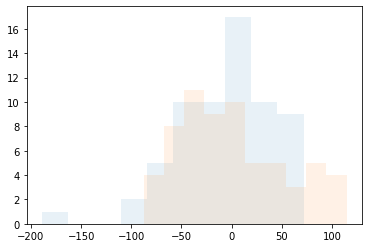

In [72]:
plt.hist(z1[:,1].detach().cpu(),alpha=0.1)
#plt.hist(z[:,14].detach().cpu(),alpha=0.1)
plt.hist(z2[:,2].detach().cpu(),alpha=0.1)

In [ ]:
nn.fc[0].weight

In [ ]:
nn.fc[0].weight.grad

In [ ]:
z1

In [ ]:
z2

In [73]:
allStar =  load("allStar_training_restricted")[:10000]
upper_temp_cut = allStar["Teff"]<7000
lower_temp_cut = allStar["Teff"]>3500
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
ni_outliercut = allStar["Ni_FE"]>-5



combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

In [74]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[combined_cut][param] for param in considered_parameters])[:,:n_data].T)

In [75]:
with torch.no_grad():
    z = nn(torch.tensor(dataset[0:10000][0]).to(device))

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
with torch.no_grad():
    g = proj(torch.tensor(z).to(device))
    g= F.normalize(g, dim=1)

In [76]:
zs = vector.Vector(z[combined_cut].detach().cpu().numpy())

In [ ]:
gs = vector.Vector(g[combined_cut].detach().cpu().numpy())


In [77]:
w = vector.LinearTransformation(zs,y)

In [78]:
nonlinear_w = vector.NonLinearTransformation(zs,y)
nonlinear_w.fit(n_epochs=500)

err:45.07054901123047
err:39.476619720458984
err:35.60551452636719
err:34.89774703979492
err:27.737503051757812
err:21.74968719482422
err:20.69246482849121
err:17.018415451049805
err:16.3027286529541
err:14.997246742248535
err:12.29849624633789
err:12.695012092590332
err:10.606642723083496
err:11.927179336547852
err:12.6316556930542
err:9.656005859375
err:10.944756507873535
err:8.983114242553711
err:8.25188159942627
err:8.800106048583984
err:8.029339790344238
err:8.160343170166016
err:8.207618713378906
err:6.377988338470459
err:6.941477298736572
err:5.999131202697754
err:5.754951477050781
err:5.022131443023682
err:6.145687580108643
err:5.1134161949157715
err:4.434206008911133
err:5.726253986358643
err:5.442759990692139
err:5.556093692779541
err:5.491481781005859
err:4.7015252113342285
err:4.407526016235352
err:3.778174638748169
err:4.65455436706543
err:3.706162929534912
err:3.7258548736572266
err:3.2710506916046143
err:3.3628551959991455
err:3.250966787338257
err:3.0824851989746094
err

err:0.6461254954338074
err:0.6713491082191467
err:0.6137959361076355
err:0.6869672536849976
err:0.7744269967079163
err:0.8525170087814331
err:0.8234146237373352
err:0.7672192454338074
err:0.6476096510887146
err:0.752143144607544
err:0.717373788356781
err:0.7467067837715149
err:0.7027788162231445
err:0.6888493299484253
err:0.6195836067199707
err:0.6368816494941711
err:0.5862552523612976
err:0.7497570514678955
err:0.6598756313323975
err:0.7783567905426025
err:0.5719558596611023
err:0.6411823034286499
err:0.6725488901138306
err:0.6378151774406433
err:0.6505329012870789
err:0.7198237180709839
err:0.6167688965797424
err:0.738334596157074
err:0.601523756980896
err:0.569726288318634
err:0.5389910936355591
err:0.6145039200782776
err:0.5305226445198059
err:0.5355081558227539
err:0.689409077167511
err:0.6364396810531616
err:0.6510012149810791
err:0.7581632137298584
err:0.6800003051757812
err:0.6574097871780396
err:0.538084089756012
err:0.7215763330459595
err:0.6070535778999329
err:0.540978312492

err:0.3501899242401123
err:0.31771761178970337
err:0.32579731941223145
err:0.3904666602611542
err:0.36171096563339233
err:0.38483479619026184
err:0.4249928593635559
err:0.3769572079181671
err:0.3724771738052368
err:0.3209802210330963
err:0.42106348276138306
err:0.35965579748153687
err:0.3269657492637634
err:0.33244505524635315
err:0.31098470091819763
err:0.34100210666656494
err:0.2691882848739624
err:0.3906206786632538
err:0.3492640256881714
err:0.32369863986968994
err:0.32882553339004517
err:0.3264392614364624
err:0.32914209365844727
err:0.36906030774116516
err:0.3545339107513428
err:0.3495311439037323
err:0.35376670956611633
err:0.31492161750793457
err:0.3450736105442047
err:0.2867192327976227
err:0.2635367512702942
err:0.3181311786174774
err:0.32913458347320557
err:0.32167086005210876
err:0.3610262870788574
err:0.3563254773616791
err:0.4208952486515045
err:0.35495856404304504
err:0.345206618309021
err:0.3485073447227478
err:0.4408362805843353
err:0.4341770112514496
err:0.33292365074

err:0.23633988201618195
err:0.25978192687034607
err:0.25103822350502014
err:0.2529926002025604
err:0.24744190275669098
err:0.22582347691059113
err:0.24697719514369965
err:0.2017977237701416
err:0.1900927573442459
err:0.22685781121253967
err:0.238611102104187
err:0.22530832886695862
err:0.24773122370243073
err:0.24977223575115204
err:0.2965947985649109
err:0.25067684054374695
err:0.24346837401390076
err:0.2516489326953888
err:0.3098340332508087
err:0.2983505427837372
err:0.2368447631597519
err:0.26369497179985046
err:0.21894079446792603
err:0.2546923756599426
err:0.26046469807624817
err:0.28947168588638306
err:0.30260682106018066
err:0.2698691785335541
err:0.24975401163101196
err:0.2515398859977722
err:0.27074921131134033
err:0.2687792181968689
err:0.2720808982849121
err:0.25391271710395813
err:0.23324961960315704
err:0.24086228013038635
err:0.20760437846183777
err:0.2722146809101105
err:0.25522324442863464
err:0.2781912386417389
err:0.20945322513580322
err:0.25537368655204773
err:0.257

err:0.17244553565979004
err:0.1881328821182251
err:0.1876513510942459
err:0.22244003415107727
err:0.19104823470115662
err:0.18623444437980652
err:0.19623173773288727
err:0.23151327669620514
err:0.22053977847099304
err:0.18010468780994415
err:0.19827380776405334
err:0.1679607331752777
err:0.19778034090995789
err:0.19537343084812164
err:0.22076614201068878
err:0.23302192986011505
err:0.20814713835716248
err:0.1925613135099411
err:0.19303077459335327
err:0.20501406490802765
err:0.20572538673877716
err:0.2062101811170578
err:0.19334863126277924
err:0.1779719591140747
err:0.1863315850496292
err:0.15934622287750244
err:0.2068222314119339
err:0.1990935504436493
err:0.20836548507213593
err:0.16376037895679474
err:0.19780485332012177
err:0.195953831076622
err:0.1734042465686798
err:0.18811091780662537
err:0.18623854219913483
err:0.1730455756187439
err:0.20738036930561066
err:0.1805718094110489
err:0.17620128393173218
err:0.14511360228061676
err:0.17382444441318512
err:0.16141027212142944
err:0.

err:0.1396573930978775
err:0.15175949037075043
err:0.12306901812553406
err:0.11924900114536285
err:0.13377588987350464
err:0.14584027230739594
err:0.1381593644618988
err:0.1495424211025238
err:0.14770866930484772
err:0.1747814416885376
err:0.15090927481651306
err:0.14935554563999176
err:0.15674573183059692
err:0.1816575676202774
err:0.1704833060503006
err:0.14048998057842255
err:0.15679815411567688
err:0.1368405669927597
err:0.15898217260837555
err:0.15589140355587006
err:0.17804303765296936
err:0.18389804661273956
err:0.16726171970367432
err:0.15498249232769012
err:0.1544719934463501
err:0.1632053554058075
err:0.16435714066028595
err:0.16359266638755798
err:0.15552715957164764
err:0.14463181793689728
err:0.1519424021244049
err:0.12886428833007812
err:0.16290156543254852
err:0.15957492589950562
err:0.16330459713935852
err:0.13423492014408112
err:0.15941858291625977
err:0.1544237732887268
err:0.1382422298192978
err:0.14905022084712982
err:0.14621442556381226
err:0.14073145389556885
err:

err:0.12021347135305405
err:0.098326176404953
err:0.09340919554233551
err:0.10445590317249298
err:0.11586349457502365
err:0.10984902828931808
err:0.11904678493738174
err:0.11765917390584946
err:0.13604213297367096
err:0.11773926019668579
err:0.11998733878135681
err:0.12277187407016754
err:0.1424274742603302
err:0.13150958716869354
err:0.1102568581700325
err:0.12344246357679367
err:0.11043713986873627
err:0.12644177675247192
err:0.12368734925985336
err:0.14162218570709229
err:0.14244344830513
err:0.13329832255840302
err:0.12240974605083466
err:0.12248855829238892
err:0.129295215010643
err:0.12812767922878265
err:0.1280110478401184
err:0.12487471848726273
err:0.11551952362060547
err:0.12329366058111191
err:0.10261774808168411
err:0.12554419040679932
err:0.12576358020305634
err:0.12657752633094788
err:0.10871327668428421
err:0.12565165758132935
err:0.11999092251062393
err:0.1089714840054512
err:0.11720111966133118
err:0.1151442751288414
err:0.11345774680376053
err:0.12899142503738403
err:

err:0.10290771722793579
err:0.09412011504173279
err:0.10545235872268677
err:0.1036849394440651
err:0.12031671404838562
err:0.11845723539590836
err:0.11166112869977951
err:0.10232842713594437
err:0.10305424779653549
err:0.10905824601650238
err:0.1060488298535347
err:0.10635794699192047
err:0.10550305992364883
err:0.09707894176244736
err:0.1039283499121666
err:0.08658727258443832
err:0.10354500263929367
err:0.10484600067138672
err:0.10472776740789413
err:0.0918130874633789
err:0.1059110015630722
err:0.09996017813682556
err:0.0904727354645729
err:0.09801515191793442
err:0.09739097952842712
err:0.09632764011621475
err:0.10624833405017853
err:0.09461584687232971
err:0.09422948211431503
err:0.0754440575838089
err:0.09641699492931366
err:0.08693518489599228
err:0.08728144317865372
err:0.09895121306180954
err:0.10477975755929947
err:0.10610930621623993
err:0.10157419741153717
err:0.09463407099246979
err:0.10219389945268631
err:0.08477737754583359
err:0.11474398523569107
err:0.09265651553869247

err:0.0746777206659317
err:0.08666016161441803
err:0.08880896866321564
err:0.08697797358036041
err:0.07829641550779343
err:0.09061405807733536
err:0.08433977514505386
err:0.0761650875210762
err:0.08258315920829773
err:0.08406452089548111
err:0.08163642138242722
err:0.08901728689670563
err:0.0799395740032196
err:0.0811169221997261
err:0.06406501680612564
err:0.08113034069538116
err:0.07349476963281631
err:0.07545008510351181
err:0.08454088866710663
err:0.0886949971318245
err:0.09105807542800903
err:0.08694841712713242
err:0.08034084737300873
err:0.08699555695056915
err:0.07199758291244507
err:0.0964629277586937
err:0.07775647938251495
err:0.08015084266662598
err:0.07872246205806732
err:0.08177205175161362
err:0.07786484062671661
err:0.07004918903112411
err:0.09073300659656525
err:0.07935816794633865
err:0.07670893520116806
err:0.0810992568731308
err:0.07464549690485
err:0.08216127008199692
err:0.08148670196533203
err:0.0815344899892807
err:0.08135932683944702
err:0.08056193590164185
err

err:0.06817318499088287
err:0.06327974796295166
err:0.06564248353242874
err:0.07215117663145065
err:0.07501696795225143
err:0.0791984498500824
err:0.07606138288974762
err:0.06877639889717102
err:0.07520373910665512
err:0.06214887276291847
err:0.08268755674362183
err:0.06636276841163635
err:0.06941218674182892
err:0.06829150021076202
err:0.0698816105723381
err:0.06700540333986282
err:0.060875602066516876
err:0.07904153317213058
err:0.06908313930034637
err:0.06690604984760284
err:0.07043986022472382
err:0.06553230434656143
err:0.071025051176548
err:0.06936907768249512
err:0.07027861475944519
err:0.07013840228319168
err:0.06939009577035904
err:0.06592042744159698
err:0.06843621283769608
err:0.05969319865107536
err:0.05590807646512985
err:0.06153581291437149
err:0.06982412189245224
err:0.06408066302537918
err:0.06839663535356522
err:0.07003527134656906
err:0.0777292251586914
err:0.0701899379491806
err:0.07060037553310394
err:0.06883439421653748
err:0.08268493413925171
err:0.075959637761116

err:0.0580756776034832
err:0.05356212705373764
err:0.06893594563007355
err:0.06023627892136574
err:0.058198217302560806
err:0.06173902004957199
err:0.05840344727039337
err:0.06223459914326668
err:0.060126446187496185
err:0.06125389412045479
err:0.061162181198596954
err:0.060761429369449615
err:0.05734715983271599
err:0.05855242535471916
err:0.051513876765966415
err:0.04872477799654007
err:0.05305340513586998
err:0.060762979090213776
err:0.055231984704732895
err:0.0585225485265255
err:0.06131477653980255
err:0.0666603147983551
err:0.06072347238659859
err:0.06083538383245468
err:0.05974229797720909
err:0.07064367085695267
err:0.06567114591598511
err:0.056424789130687714
err:0.06101948022842407
err:0.05992851406335831
err:0.06515108793973923
err:0.06390346586704254
err:0.07360852509737015
err:0.07193390280008316
err:0.06706475466489792
err:0.06419520080089569
err:0.06385728716850281
err:0.06716738641262054
err:0.06399188935756683
err:0.06522533297538757
err:0.06293638050556183
err:0.05847

err:0.042822156101465225
err:0.04612227901816368
err:0.05301585793495178
err:0.047946009784936905
err:0.050866611301898956
err:0.05364144593477249
err:0.05751284956932068
err:0.05246293544769287
err:0.053146567195653915
err:0.05206789821386337
err:0.06097393110394478
err:0.05733758956193924
err:0.04920540750026703
err:0.052398595958948135
err:0.05282437801361084
err:0.056740544736385345
err:0.05549883842468262
err:0.06365034729242325
err:0.06227770820260048
err:0.057950664311647415
err:0.05618428811430931
err:0.054947178810834885
err:0.05859364941716194
err:0.055809665471315384
err:0.056830763816833496
err:0.05403515696525574
err:0.051008980721235275
err:0.057815857231616974
err:0.048829853534698486
err:0.05357200652360916
err:0.055655863136053085
err:0.05378715693950653
err:0.0498325452208519
err:0.05524151027202606
err:0.05255740135908127
err:0.049107227474451065
err:0.051364973187446594
err:0.05303329601883888
err:0.050271958112716675
err:0.0558619387447834
err:0.052211444824934006


err:0.0499197281897068
err:0.04829050227999687
err:0.05527423322200775
err:0.054628029465675354
err:0.05064025893807411
err:0.04940181225538254
err:0.04778548702597618
err:0.05164695903658867
err:0.04896940290927887
err:0.0500347837805748
err:0.04687432199716568
err:0.045015983283519745
err:0.051373373717069626
err:0.04304695129394531
err:0.04671885073184967
err:0.04851265251636505
err:0.0469256229698658
err:0.04367291182279587
err:0.04811207950115204
err:0.046555884182453156
err:0.043568454682826996
err:0.04487919434905052
err:0.04614521935582161
err:0.04477282986044884
err:0.04900745674967766
err:0.04625669866800308
err:0.045855872333049774
err:0.03565624728798866
err:0.04340505227446556
err:0.0418383814394474
err:0.042353879660367966
err:0.047466762363910675
err:0.04746391251683235
err:0.05062989145517349
err:0.050680167973041534
err:0.04392760619521141
err:0.04893588647246361
err:0.04071221873164177
err:0.05216405540704727
err:0.041321251541376114
err:0.04662333428859711
err:0.0452

err:0.04245730862021446
err:0.04119224473834038
err:0.03856629878282547
err:0.04215181991457939
err:0.04168420284986496
err:0.03892869874835014
err:0.039693720638751984
err:0.04050939157605171
err:0.04021702706813812
err:0.04305297136306763
err:0.0411972738802433
err:0.04079189896583557
err:0.03162652999162674
err:0.03821977227926254
err:0.037462636828422546
err:0.03771272674202919
err:0.04243416711688042
err:0.042073726654052734
err:0.04444659501314163
err:0.04502730816602707
err:0.03884709253907204
err:0.043313346803188324
err:0.03621441498398781
err:0.046137142926454544
err:0.03634427860379219
err:0.04138262942433357
err:0.04021073877811432
err:0.040772780776023865
err:0.03900512307882309
err:0.036037541925907135
err:0.04449612274765968
err:0.03959246724843979
err:0.03835348039865494
err:0.04236961156129837
err:0.04050867632031441
err:0.04149063676595688
err:0.039964236319065094
err:0.04096110910177231
err:0.04042087122797966
err:0.041440870612859726
err:0.03703901916742325
err:0.03

err:0.03362714499235153
err:0.038076478987932205
err:0.03772785887122154
err:0.039252594113349915
err:0.04011324793100357
err:0.0346517451107502
err:0.03850959241390228
err:0.03253613039851189
err:0.04115280508995056
err:0.03226574510335922
err:0.036794550716876984
err:0.03605456277728081
err:0.036841560155153275
err:0.03481269255280495
err:0.03198736906051636
err:0.039674531668424606
err:0.03530879318714142
err:0.03417977690696716
err:0.0379062220454216
err:0.036527927964925766
err:0.03724414110183716
err:0.0358719527721405
err:0.03651876747608185
err:0.0356144905090332
err:0.03722511976957321
err:0.0328025259077549
err:0.032757606357336044
err:0.029844481498003006
err:0.028713010251522064
err:0.03155016154050827
err:0.03620784357190132
err:0.032229483127593994
err:0.03443894162774086
err:0.03763269633054733
err:0.03674311935901642
err:0.034952014684677124
err:0.03607294335961342
err:0.034734923392534256
err:0.03873128816485405
err:0.03872810676693916
err:0.032626476138830185
err:0.03

err:0.02848958782851696
err:0.03594844415783882
err:0.031552307307720184
err:0.03059721738100052
err:0.03416091948747635
err:0.033227093517780304
err:0.03363528102636337
err:0.032339777797460556
err:0.0327141247689724
err:0.031555794179439545
err:0.033565860241651535
err:0.029371704906225204
err:0.028971364721655846
err:0.02699732594192028
err:0.025471651926636696
err:0.028417814522981644
err:0.03243006393313408
err:0.028669660910964012
err:0.030801577493548393
err:0.03425578027963638
err:0.03249143064022064
err:0.0315520241856575
err:0.03243439644575119
err:0.031105486676096916
err:0.03429080545902252
err:0.03458878770470619
err:0.02906215190887451
err:0.030197786167263985
err:0.03317879140377045
err:0.03490332514047623
err:0.031845662742853165
err:0.03667193651199341
err:0.03716643154621124
err:0.03482229635119438
err:0.03463739529252052
err:0.03272121027112007
err:0.03565790876746178
err:0.03367284685373306
err:0.03474585711956024
err:0.031205521896481514
err:0.03184748813509941
err

err:0.02577783539891243
err:0.029106661677360535
err:0.025645650923252106
err:0.027775170281529427
err:0.03100011497735977
err:0.028831297531723976
err:0.028629418462514877
err:0.029211439192295074
err:0.028100553900003433
err:0.03035997785627842
err:0.030963702127337456
err:0.026059145107865334
err:0.027082182466983795
err:0.02994837425649166
err:0.03151039034128189
err:0.028394222259521484
err:0.032670605927705765
err:0.033319246023893356
err:0.031326547265052795
err:0.031495917588472366
err:0.029464824125170708
err:0.032150186598300934
err:0.030413981527090073
err:0.031398363411426544
err:0.028052639216184616
err:0.029224688187241554
err:0.03387310728430748
err:0.027687830850481987
err:0.028241047635674477
err:0.029217466711997986
err:0.028276249766349792
err:0.027134057134389877
err:0.02835843525826931
err:0.02987745963037014
err:0.028635375201702118
err:0.028063781559467316
err:0.02832290157675743
err:0.029112985357642174
err:0.029746131971478462
err:0.028240904211997986
err:0.028

err:0.025419004261493683
err:0.02925179898738861
err:0.029979325830936432
err:0.028357824310660362
err:0.028704557567834854
err:0.026634857058525085
err:0.028986291959881783
err:0.02750272862613201
err:0.02842612937092781
err:0.02521810680627823
err:0.026841307058930397
err:0.03109726682305336
err:0.025192292407155037
err:0.02548805996775627
err:0.026224931702017784
err:0.025448570027947426
err:0.024631759151816368
err:0.02535291016101837
err:0.02696681022644043
err:0.0260221716016531
err:0.02533125691115856
err:0.025581836700439453
err:0.026561278849840164
err:0.026871172711253166
err:0.025439374148845673
err:0.026206735521554947
err:0.02061723731458187
err:0.02369660511612892
err:0.024006135761737823
err:0.024231141433119774
err:0.028285471722483635
err:0.027487043291330338
err:0.02743258886039257
err:0.028347546234726906
err:0.02502245083451271
err:0.027527466416358948
err:0.02349543757736683
err:0.029088469222187996
err:0.022850025445222855
err:0.026374956592917442
err:0.0266814716

err:0.023147791624069214
err:0.022518405690789223
err:0.022775718942284584
err:0.0243490282446146
err:0.023592036217451096
err:0.023068850859999657
err:0.02330193668603897
err:0.02413000725209713
err:0.024349691346287727
err:0.023166490718722343
err:0.023937711492180824
err:0.018714409321546555
err:0.02157723531126976
err:0.02204451896250248
err:0.02231638878583908
err:0.025900287553668022
err:0.02522873692214489
err:0.024974675849080086
err:0.02572525478899479
err:0.022932007908821106
err:0.025143379345536232
err:0.021362105384469032
err:0.026543118059635162
err:0.020686477422714233
err:0.023951027542352676
err:0.024383919313549995
err:0.024653926491737366
err:0.023094139993190765
err:0.020529426634311676
err:0.027062706649303436
err:0.023350443691015244
err:0.021446483209729195
err:0.025635380297899246
err:0.025494182482361794
err:0.0247745830565691
err:0.023757517337799072
err:0.023600200191140175
err:0.02307458221912384
err:0.024553751572966576
err:0.021996453404426575
err:0.020514

err:0.02389315702021122
err:0.023238081485033035
err:0.0231332965195179
err:0.023610299453139305
err:0.021032264456152916
err:0.02324826642870903
err:0.0194692462682724
err:0.02428284101188183
err:0.018866388127207756
err:0.02219379134476185
err:0.022444380447268486
err:0.02271285466849804
err:0.021262042224407196
err:0.01874416135251522
err:0.02493605762720108
err:0.02147933654487133
err:0.019280564039945602
err:0.023720674216747284
err:0.023693256080150604
err:0.022599944844841957
err:0.021764781326055527
err:0.021495601162314415
err:0.02128519117832184
err:0.022504055872559547
err:0.020344994962215424
err:0.0185985304415226
err:0.0185882318764925
err:0.01682569459080696
err:0.019814740866422653
err:0.0212292168289423
err:0.019073868170380592
err:0.020740853622555733
err:0.023748375475406647
err:0.020748943090438843
err:0.021616840735077858
err:0.021901000291109085
err:0.021072156727313995
err:0.02191472053527832
err:0.022359946742653847
err:0.019603803753852844
err:0.019471097737550

err:0.01987799070775509
err:0.01756306365132332
err:0.022164545953273773
err:0.022032804787158966
err:0.020719515159726143
err:0.0200774148106575
err:0.01980080083012581
err:0.019831031560897827
err:0.020581059157848358
err:0.018917227163910866
err:0.017086254432797432
err:0.017187070101499557
err:0.015562734566628933
err:0.018463706597685814
err:0.019510943442583084
err:0.01768491417169571
err:0.019165685400366783
err:0.021988140419125557
err:0.019107474014163017
err:0.020003236830234528
err:0.020132718607783318
err:0.019493458792567253
err:0.020207228139042854
err:0.02035086415708065
err:0.018143320456147194
err:0.01786309853196144
err:0.020718101412057877
err:0.021983155980706215
err:0.018751205876469612
err:0.020950302481651306
err:0.022249365225434303
err:0.02137775719165802
err:0.021407894790172577
err:0.020144997164607048
err:0.02168157324194908
err:0.020583156496286392
err:0.0214557945728302
err:0.018698547035455704
err:0.020439106971025467
err:0.024185175076127052
err:0.019254

err:0.017978979274630547
err:0.016491692513227463
err:0.01775708980858326
err:0.02038923278450966
err:0.017647026106715202
err:0.018551213666796684
err:0.01867035962641239
err:0.018147531896829605
err:0.018547333776950836
err:0.018657244741916656
err:0.016836700960993767
err:0.016497265547513962
err:0.019249694421887398
err:0.020329536870121956
err:0.017267407849431038
err:0.019184300675988197
err:0.020457470789551735
err:0.01976662129163742
err:0.0197646152228117
err:0.01863323338329792
err:0.01985587738454342
err:0.019160756841301918
err:0.019885238260030746
err:0.017109928652644157
err:0.01896039955317974
err:0.022619782015681267
err:0.017881959676742554
err:0.017828235402703285
err:0.017718659713864326
err:0.017989294603466988
err:0.017569683492183685
err:0.017169831320643425
err:0.018486984074115753
err:0.017794396728277206
err:0.01777864247560501
err:0.018117304891347885
err:0.01841721124947071
err:0.018244680017232895
err:0.01810009591281414
err:0.018558280542492867
err:0.014278

err:0.01770676113665104
err:0.018885092809796333
err:0.018409840762615204
err:0.018375486135482788
err:0.017266618087887764
err:0.018457021564245224
err:0.0179385244846344
err:0.018429294228553772
err:0.01591658592224121
err:0.01764800027012825
err:0.021260323002934456
err:0.016659557819366455
err:0.016624191775918007
err:0.016427412629127502
err:0.016795381903648376
err:0.016386689618229866
err:0.015928007662296295
err:0.017167532816529274
err:0.016490863636136055
err:0.016592172905802727
err:0.016884760931134224
err:0.01710839383304119
err:0.016854235902428627
err:0.016925932839512825
err:0.017375389114022255
err:0.01337472628802061
err:0.015933670103549957
err:0.016109388321638107
err:0.017142124474048615
err:0.019084762781858444
err:0.01880350150167942
err:0.018564842641353607
err:0.01914551481604576
err:0.016663169488310814
err:0.018378688022494316
err:0.015349187888205051
err:0.019445698708295822
err:0.015034790150821209
err:0.017652513459324837
err:0.01769823394715786
err:0.0184

err:0.015257803723216057
err:0.014821083284914494
err:0.016092412173748016
err:0.015359888784587383
err:0.015426578931510448
err:0.015792984515428543
err:0.015956971794366837
err:0.01563284732401371
err:0.01580781862139702
err:0.01629563979804516
err:0.012654278427362442
err:0.014836623333394527
err:0.015134887769818306
err:0.0162848848849535
err:0.01814183034002781
err:0.017759399488568306
err:0.017363328486680984
err:0.018149591982364655
err:0.01573999412357807
err:0.01728108525276184
err:0.014433356001973152
err:0.018243785947561264
err:0.014191691763699055
err:0.01661665365099907
err:0.016630645841360092
err:0.017437975853681564
err:0.015759628266096115
err:0.013977632857859135
err:0.01922893524169922
err:0.01590869389474392
err:0.013773441314697266
err:0.018222074955701828
err:0.01826520264148712
err:0.016508184373378754
err:0.0165387149900198
err:0.015926627442240715
err:0.016549644991755486
err:0.016188643872737885
err:0.015446756966412067
err:0.01357609499245882
err:0.014104109

err:0.017232757061719894
err:0.01688724011182785
err:0.016369767487049103
err:0.017284924164414406
err:0.014937687665224075
err:0.01627114973962307
err:0.013648769818246365
err:0.017147136852145195
err:0.013376625254750252
err:0.01569618470966816
err:0.015723781660199165
err:0.016537560150027275
err:0.01476391963660717
err:0.013298427686095238
err:0.018309080973267555
err:0.014922366477549076
err:0.012902812100946903
err:0.017307506874203682
err:0.017383543774485588
err:0.015546420589089394
err:0.01577048748731613
err:0.015063035301864147
err:0.015499603003263474
err:0.015186927281320095
err:0.01463798526674509
err:0.012761839665472507
err:0.01340582873672247
err:0.011883484199643135
err:0.013932254165410995
err:0.014550856314599514
err:0.01352140586823225
err:0.014421582221984863
err:0.016565898433327675
err:0.014133380725979805
err:0.015019032172858715
err:0.014805132523179054
err:0.014877318404614925
err:0.01469617523252964
err:0.014749336987733841
err:0.013853165321052074
err:0.013

err:0.014142580330371857
err:0.012178699485957623
err:0.016546083614230156
err:0.01660487987101078
err:0.014754164963960648
err:0.015054671093821526
err:0.014315049163997173
err:0.014843333512544632
err:0.014361122623085976
err:0.01393888145685196
err:0.01205574069172144
err:0.01280608493834734
err:0.011278114281594753
err:0.01324192713946104
err:0.013756106607615948
err:0.012874879874289036
err:0.013784205541014671
err:0.015574286691844463
err:0.013336711563169956
err:0.01423561479896307
err:0.01393569353967905
err:0.014137651771306992
err:0.013770094141364098
err:0.01384113822132349
err:0.013187802396714687
err:0.012371350079774857
err:0.015227245166897774
err:0.015632405877113342
err:0.012889456935226917
err:0.01420907024294138
err:0.015537909232079983
err:0.014987095259130001
err:0.01509340014308691
err:0.014208820648491383
err:0.015366239473223686
err:0.015094194561243057
err:0.015259609557688236
err:0.012854385189712048
err:0.014370829798281193
err:0.017988689243793488
err:0.0136

err:0.013040558435022831
err:0.012295583263039589
err:0.013262997381389141
err:0.014798467047512531
err:0.012559694238007069
err:0.013536907732486725
err:0.013299597427248955
err:0.01343240775167942
err:0.01309413556009531
err:0.013093414716422558
err:0.012733063660562038
err:0.011592799797654152
err:0.01463697012513876
err:0.015081607736647129
err:0.012267909944057465
err:0.013443591073155403
err:0.01503125112503767
err:0.014356929808855057
err:0.014443272724747658
err:0.013840625993907452
err:0.014673999510705471
err:0.014571194536983967
err:0.014794421382248402
err:0.012202015146613121
err:0.01369398832321167
err:0.01729079894721508
err:0.013015191070735455
err:0.012836415320634842
err:0.012730144895613194
err:0.013232741504907608
err:0.012777735479176044
err:0.012309553101658821
err:0.013258464634418488
err:0.01280124206095934
err:0.012493306770920753
err:0.012993622571229935
err:0.013217913918197155
err:0.012510035187005997
err:0.012915236875414848
err:0.013858637772500515
err:0.0

err:0.012756106443703175
err:0.015088458545506
err:0.014224942773580551
err:0.013924926519393921
err:0.01418263465166092
err:0.01438397727906704
err:0.014015914872288704
err:0.014816774055361748
err:0.01186266727745533
err:0.013024337589740753
err:0.016802512109279633
err:0.012948841787874699
err:0.012257546186447144
err:0.012276558205485344
err:0.012852094136178493
err:0.012418221682310104
err:0.01208808459341526
err:0.012598283588886261
err:0.012504211626946926
err:0.012107191607356071
err:0.012674367986619473
err:0.012769901193678379
err:0.01241271197795868
err:0.012369329109787941
err:0.013097686693072319
err:0.010729791596531868
err:0.011322543025016785
err:0.012915007770061493
err:0.015525799244642258
err:0.014983446337282658
err:0.015303500927984715
err:0.015510441735386848
err:0.01590740494430065
err:0.01469937339425087
err:0.01610383205115795
err:0.012652317062020302
err:0.015827160328626633
err:0.013950596563518047
err:0.01403834018856287
err:0.01405166182667017
err:0.0161231

err:0.01291561033576727
err:0.015298471786081791
err:0.01442444697022438
err:0.012385156005620956
err:0.014661973342299461
err:0.015468180179595947
err:0.012348360382020473
err:0.01564420759677887
err:0.015421317890286446
err:0.012782410718500614
err:0.013020459562540054
err:0.015459802001714706
err:0.014085141941905022
err:0.016154509037733078
err:0.01591162011027336
err:0.01599675789475441
err:0.014597957022488117
err:0.01827482506632805
err:0.013659197837114334
err:0.01731771044433117
err:0.015419608913362026
err:0.016773400828242302
err:0.012811899185180664
err:0.016736866906285286
err:0.017620302736759186
err:0.016261247918009758
err:0.016284745186567307
err:0.016149934381246567
err:0.019973592832684517
err:0.015735037624835968
err:0.017887767404317856
err:0.020055945962667465
err:0.017914561554789543
err:0.017185436561703682
err:0.019392436370253563
err:0.01807224191725254
err:0.015039531514048576
err:0.015158936381340027
err:0.016358794644474983
err:0.014341742731630802
err:0.01

err:0.014560103416442871
err:0.013900450430810452
err:0.013824108988046646
err:0.01614496298134327
err:0.012228596955537796
err:0.014546871185302734
err:0.01438198797404766
err:0.015917109325528145
err:0.011729186400771141
err:0.014962375164031982
err:0.015013165771961212
err:0.015743006020784378
err:0.014249535277485847
err:0.013346430845558643
err:0.01712736114859581
err:0.015107743442058563
err:0.013133593834936619
err:0.0167375560849905
err:0.016720740124583244
err:0.016223672777414322
err:0.014863095246255398
err:0.013718516565859318
err:0.01562507264316082
err:0.015184959396719933
err:0.012221980839967728
err:0.011881925165653229
err:0.014246056787669659
err:0.011137404479086399
err:0.012505059130489826
err:0.013147526420652866
err:0.013770867139101028
err:0.013177663087844849
err:0.013836374506354332
err:0.011692994274199009
err:0.012381204403936863
err:0.012274748645722866
err:0.012336469255387783
err:0.012568033300340176
err:0.01178082637488842
err:0.011934918351471424
err:0.0

err:0.014999485574662685
err:0.012565011158585548
err:0.01617218367755413
err:0.01606700010597706
err:0.015412010252475739
err:0.015408214181661606
err:0.013690845109522343
err:0.013888954184949398
err:0.015464109368622303
err:0.013234501704573631
err:0.011174348182976246
err:0.012340251356363297
err:0.011783799156546593
err:0.012550917454063892
err:0.012139583006501198
err:0.012400311417877674
err:0.013753519393503666
err:0.01414760947227478
err:0.011244508437812328
err:0.012420766986906528
err:0.012526695616543293
err:0.012167814187705517
err:0.012547253631055355
err:0.011962167918682098
err:0.011024600826203823
err:0.00991519819945097
err:0.01418101042509079
err:0.012733184732496738
err:0.011367011815309525
err:0.012197347357869148
err:0.014346491545438766
err:0.013700352050364017
err:0.011963127180933952
err:0.015668151900172234
err:0.012862766161561012
err:0.01211376953870058
err:0.01401427574455738
err:0.011471535079181194
err:0.012208630330860615
err:0.01538833137601614
err:0.01

err:0.012118203565478325
err:0.010704359039664268
err:0.01246801670640707
err:0.014548683539032936
err:0.011240546591579914
err:0.01176475454121828
err:0.012419309467077255
err:0.011926795355975628
err:0.011626220308244228
err:0.011980031616985798
err:0.014986471273005009
err:0.009132145904004574
err:0.014811700209975243
err:0.016498638316988945
err:0.012671376578509808
err:0.010608953423798084
err:0.015330693684518337
err:0.014979598112404346
err:0.011602269485592842
err:0.013920367695391178
err:0.013326476328074932
err:0.012265708297491074
err:0.012730633839964867
err:0.011646724306046963
err:0.012940876185894012
err:0.015177822671830654
err:0.011251555755734444
err:0.012019776739180088
err:0.01048772782087326
err:0.011227177456021309
err:0.01062789373099804
err:0.01192663423717022
err:0.010662573389708996
err:0.010411536321043968
err:0.01047710794955492
err:0.012400810606777668
err:0.009757025167346
err:0.010034408420324326
err:0.011488595977425575
err:0.01235171128064394
err:0.0095

err:0.011826044879853725
err:0.009781560860574245
err:0.012168850749731064
err:0.012787173502147198
err:0.011085962876677513
err:0.011428222991526127
err:0.0119433319196105
err:0.012334254570305347
err:0.012640716508030891
err:0.010378086008131504
err:0.012510279193520546
err:0.014660212211310863
err:0.01076902262866497
err:0.010208865627646446
err:0.01057618111371994
err:0.011117029935121536
err:0.009688248857855797
err:0.010156084783375263
err:0.010548694990575314
err:0.010439254343509674
err:0.009737457148730755
err:0.011661479249596596
err:0.009635115042328835
err:0.009976580739021301
err:0.01017171423882246
err:0.011141161434352398
err:0.009268850088119507
err:0.009893250651657581
err:0.010763674974441528
err:0.011912730522453785
err:0.012273752130568027
err:0.011277659796178341
err:0.011411190964281559
err:0.013077767565846443
err:0.009525490924715996
err:0.012046774849295616
err:0.011141333729028702
err:0.012376708909869194
err:0.010025856085121632
err:0.011849375441670418
err:0

err:0.010409975424408913
err:0.010771897621452808
err:0.009283888153731823
err:0.009462375193834305
err:0.010416396893560886
err:0.010184817016124725
err:0.009343563579022884
err:0.011065139435231686
err:0.00924216490238905
err:0.009656737558543682
err:0.00980136077851057
err:0.010542898438870907
err:0.008945341221988201
err:0.009234210476279259
err:0.010338791646063328
err:0.011420308612287045
err:0.011864688247442245
err:0.010930153541266918
err:0.010874444618821144
err:0.012595895677804947
err:0.009200363419950008
err:0.011645879596471786
err:0.010762911289930344
err:0.011755936779081821
err:0.009627562947571278
err:0.011161918751895428
err:0.011207005009055138
err:0.012186299078166485
err:0.010435905307531357
err:0.010452937334775925
err:0.01238221675157547
err:0.010333428159356117
err:0.009615731425583363
err:0.013725446537137032
err:0.012318090535700321
err:0.010751841589808464
err:0.011953591369092464
err:0.011640275828540325
err:0.010768542997539043
err:0.010778638534247875
err

err:0.010977152734994888
err:0.011477996595203876
err:0.010622029192745686
err:0.01051324512809515
err:0.012303766794502735
err:0.00895264744758606
err:0.01140061765909195
err:0.010485884733498096
err:0.011285428889095783
err:0.009316684678196907
err:0.0107179069891572
err:0.010834124870598316
err:0.011905290186405182
err:0.010010962374508381
err:0.010069138370454311
err:0.012056294828653336
err:0.010007481090724468
err:0.009347820654511452
err:0.0131861986592412
err:0.011906245723366737
err:0.010331081226468086
err:0.011631274595856667
err:0.011220837011933327
err:0.01042656134814024
err:0.010378443636000156
err:0.01013701781630516
err:0.009336583316326141
err:0.00886627845466137
err:0.0077600497752428055
err:0.009746936149895191
err:0.010822968557476997
err:0.009246187284588814
err:0.00985716562718153
err:0.011835343204438686
err:0.009443656541407108
err:0.009709054604172707
err:0.009574119932949543
err:0.010144686326384544
err:0.009010015986859798
err:0.00936336349695921
err:0.00970

err:0.009660659357905388
err:0.011751176789402962
err:0.009734464809298515
err:0.008990024216473103
err:0.012649367563426495
err:0.011561225168406963
err:0.009972277097404003
err:0.011263448745012283
err:0.010813551023602486
err:0.010138466954231262
err:0.010038807988166809
err:0.0097908740863204
err:0.008916433900594711
err:0.008594798855483532
err:0.007465006783604622
err:0.009392139501869678
err:0.01038400363177061
err:0.008906221948564053
err:0.009525245055556297
err:0.011342943646013737
err:0.008935442194342613
err:0.009315414354205132
err:0.0092289624735713
err:0.009725425392389297
err:0.008579198271036148
err:0.00897503737360239
err:0.009179450571537018
err:0.007497565820813179
err:0.010209710337221622
err:0.010044006630778313
err:0.009592104703187943
err:0.008772257715463638
err:0.010129726491868496
err:0.01026069838553667
err:0.009686430916190147
err:0.010044226422905922
err:0.010396641679108143
err:0.010449564084410667
err:0.0115644047036767
err:0.008772550150752068
err:0.010

err:0.009018982760608196
err:0.00999488215893507
err:0.008576523512601852
err:0.009235920384526253
err:0.010913504287600517
err:0.008480608463287354
err:0.00899409968405962
err:0.008927052840590477
err:0.00934583880007267
err:0.008215160109102726
err:0.00863214023411274
err:0.008617938496172428
err:0.00723319873213768
err:0.009834395721554756
err:0.00956488773226738
err:0.009186987765133381
err:0.008542709983885288
err:0.0098662618547678
err:0.009838631376624107
err:0.009383941069245338
err:0.009691610932350159
err:0.010006737895309925
err:0.010006697848439217
err:0.011157109402120113
err:0.008485684171319008
err:0.010062670335173607
err:0.012585894204676151
err:0.00895475409924984
err:0.00824649352580309
err:0.008955186232924461
err:0.009084004908800125
err:0.008238689042627811
err:0.008016158826649189
err:0.00907132588326931
err:0.008857828564941883
err:0.008241178467869759
err:0.009260371327400208
err:0.007936074398458004
err:0.008325044997036457
err:0.008821973577141762
err:0.00900

err:0.008863306604325771
err:0.008352826349437237
err:0.009686168283224106
err:0.009498393163084984
err:0.009094731882214546
err:0.009284811094403267
err:0.009659091010689735
err:0.009630932472646236
err:0.010744648985564709
err:0.008274147287011147
err:0.009584604762494564
err:0.012221361510455608
err:0.008655271492898464
err:0.00796154048293829
err:0.00858309492468834
err:0.008679280057549477
err:0.007995834574103355
err:0.00769425556063652
err:0.00867560226470232
err:0.008551590144634247
err:0.008001910522580147
err:0.008899285458028316
err:0.007673924323171377
err:0.008036740124225616
err:0.0085833128541708
err:0.00863969698548317
err:0.007718765176832676
err:0.007787128444761038
err:0.009029295295476913
err:0.009994213469326496
err:0.010508915409445763
err:0.009697506204247475
err:0.009537006728351116
err:0.011412722989916801
err:0.008296298794448376
err:0.01047807838767767
err:0.009102776646614075
err:0.01020510122179985
err:0.008325104601681232
err:0.009412958286702633
err:0.009

err:0.008288942277431488
err:0.008319113403558731
err:0.007769798394292593
err:0.007447539363056421
err:0.008391695097088814
err:0.008255652152001858
err:0.007805241271853447
err:0.008654946461319923
err:0.007421640679240227
err:0.00785959791392088
err:0.008342749439179897
err:0.008375357836484909
err:0.007529144641011953
err:0.007524880580604076
err:0.008861390873789787
err:0.00971926748752594
err:0.010263853706419468
err:0.009444831870496273
err:0.00933295488357544
err:0.011138340458273888
err:0.00811003614217043
err:0.010266744531691074
err:0.008736155927181244
err:0.009884288534522057
err:0.008089985698461533
err:0.009136551059782505
err:0.009571779519319534
err:0.010877901688218117
err:0.008627700619399548
err:0.00856747291982174
err:0.010909514501690865
err:0.00893304031342268
err:0.007827816531062126
err:0.010998956859111786
err:0.010675616562366486
err:0.009085049852728844
err:0.010090585798025131
err:0.009506397880613804
err:0.009356725960969925
err:0.0091643575578928
err:0.00

err:0.009598380886018276
err:0.010068103671073914
err:0.009144068695604801
err:0.009206234477460384
err:0.010875726118683815
err:0.007952298037707806
err:0.010031789541244507
err:0.008460343815386295
err:0.009660156443715096
err:0.007889140397310257
err:0.008943718858063221
err:0.00933246873319149
err:0.010620728135108948
err:0.008437523618340492
err:0.008345355279743671
err:0.010764510370790958
err:0.008692759089171886
err:0.007544954773038626
err:0.010636835359036922
err:0.01039834599941969
err:0.008840516209602356
err:0.00975615531206131
err:0.009107397869229317
err:0.009116748347878456
err:0.008936385624110699
err:0.008454110473394394
err:0.007369922008365393
err:0.007635891437530518
err:0.006576137617230415
err:0.00817230436950922
err:0.008705288171768188
err:0.007741535548120737
err:0.008475102484226227
err:0.009567005559802055
err:0.0073724971152842045
err:0.008096029050648212
err:0.007933233864605427
err:0.008268376812338829
err:0.0075269462540745735
err:0.007716519292443991
er

KeyboardInterrupt: 

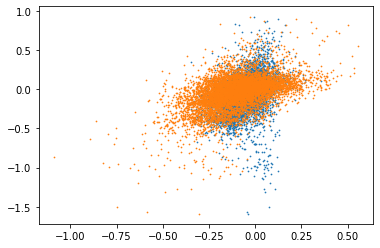

In [93]:
idx=5
plt.scatter(w.predict(zs).raw[:,idx],y.raw[:,idx],s=0.5)
plt.scatter(nonlinear_w.predict(zs).raw[:,idx],y.raw[:,idx],s=0.5)


(array([1.000e+00, 1.200e+01, 5.940e+02, 2.787e+03, 2.175e+03, 8.040e+02,
        4.730e+02, 3.540e+02, 9.300e+01, 7.000e+00]),
 array([-0.21342522, -0.14674094, -0.08005667, -0.01337239,  0.05331188,
         0.11999616,  0.18668044,  0.2533647 ,  0.320049  ,  0.38673326,
         0.45341754], dtype=float32),
 <a list of 10 Patch objects>)

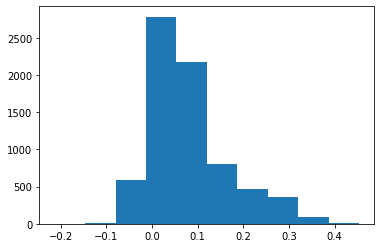

In [44]:
plt.hist(nonlinear_w.predict(zs).raw[:,idx])
#plt.hist(y.raw[:,idx])

In [ ]:
plt.hist(y.raw[:,idx])

In [ ]:
plt.scatter(nonlinear_w.predict(zs).raw[:,4],y.raw[:,4],s=0.5)

In [ ]:
dataset.dataset["aspcap"].shape

In [ ]:
spec = vector.Vector(dataset.dataset["aspcap_interpolated"])

In [ ]:
plt.plot(dataset.dataset["aspcap_err"][7])
plt.xlim(4300,4500)

In [ ]:
for i in range(100,200):
    plt.title(i)
    plt.plot(spec.normalized[i])
    plt.show()
#plt.xlim(4300,4500)

In [ ]:
np.max(np.abs(spec.centered),0).shape

In [ ]:
plt.plot(dataset.dataset["aspcap_interpolated"][109])
plt.plot(dataset.dataset["aspcap_interpolated"][7])
plt.plot(dataset.dataset["aspcap"][7])

plt.xlim(4300,4350)

In [ ]:
plt.plot(dataset.dataset["aspcap_interpolated"][109])

In [ ]:
dataset.dataset["aspcap_interpolated"][109]

### Checking representation

In [ ]:
dataset=  AspcapDataset(filename="aspcap_restricted",tensor_type=torch.FloatTensor,recenter=True)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,drop_last=True)


In [ ]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/aspcap/z10centered/ae_500.p")

In [ ]:
loss = torch.nn.L1Loss()

In [ ]:
x = torch.tensor(dataset[0:600][0]).to(device)
x_pred,_ = autoencoder(x)

In [ ]:
err= loss(x,x_pred)

In [ ]:
err.item()

In [ ]:
allStar =  load("allStar_training_restricted")[:n_data]
upper_temp_cut = allStar["Teff"]<7000
lower_temp_cut = allStar["Teff"]>3500
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
ni_outliercut = allStar["Ni_FE"]>-5



combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

In [ ]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[combined_cut][param] for param in considered_parameters])[:,:n_data].T)

In [ ]:
z = vector.LatentVector(dataset,autoencoder,n_data)

In [ ]:
z = vector.Vector(z.raw[combined_cut])

In [ ]:
w = vector.LinearTransformation(z,y)
nonlinear_w = vector.NonLinearTransformation(z,y)

In [ ]:
y_pred = nonlinear_w.network(torch.tensor(z.centered).to(device))

In [ ]:
y.normalized

In [ ]:
y_scaled_pred = y_pred.detach().cpu()*np.max(y.centered,0)+np.mean(y.raw,axis=0)


In [ ]:
y.centered

In [ ]:
plt.scatter(y.raw[:,2],y_scaled_pred[:,2].detach().cpu(),s=0.5)


In [ ]:
plt.scatter(y.normalized[:,2],y_pred[:,2].detach().cpu(),s=0.5)


In [ ]:
nonlinear_w.fit(200)

In [ ]:
for i in range(10):
    plt.title(considered_parameters[i])
    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.1,label="linear")
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.1,label="linear")

    plt.show()

In [ ]:
i=2
plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear")
plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="linear")
plt.xlim(-0.2,0.5)
plt.ylim(-0.2,0.5)

In [ ]:
for i in range(10):
    plt.title(considered_parameters[i])
    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear")
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="linear")

    plt.show()

## Baseline

In [ ]:
dataset=  AspcapDataset(filename="aspcap_restricted",tensor_type=torch.FloatTensor,recenter=False)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,drop_last=True)


In [ ]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/aspcap/z10/ae_5000.p")

In [ ]:
z = vector.LatentVector(dataset,autoencoder,n_data)

In [ ]:
z.plot(1)

In [ ]:
z = vector.Vector(z.raw[combined_cut])

In [ ]:
w = vector.LinearTransformation(z,y)
nonlinear_w  = vector.NonLinearTransformation(z,y)
nonlinear_w.fit(n_epochs = 200)

1000

In [ ]:
for i in range(10):
    plt.title(considered_parameters[i])
    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear")
    plt.show()

3000

In [ ]:
for i in range(10):
    plt.title(considered_parameters[i])
    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear")
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="linear")

    plt.show()

5000

In [ ]:
for i in range(10):
    plt.title(considered_parameters[i])
    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear")
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="linear")

    plt.show()

In [ ]:
i=2
plt.title(considered_parameters[i])
plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear")
plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="linear")

plt.show()

In [97]:
import apogee.spec.window as apwindow
apwindow

<module 'apogee.spec.window' from '/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/apogee/spec/window.py'>